## Scheinbare spezifische Widerstände für gegebene Widerstands-Tiefen-Verteilungen

Mithilfe dieses Jupyter-Notebooks können Sie scheinbare spezifische Widerstände für Schichten mit beliebigen Mächtigkeiten und Widerständen berechnen. Dazu führen Sie zunächst die erste Zelle, direkt unter dieser, aus (strg+Enter). Darin werden zusätzlich benötigte Funktionen definiert. Die eigentliche Berechnung der Widerstandskurven erfolgt dann in der Zelle darunter.

In [1]:
import numpy as np
import scipy.special as scp
import matplotlib.pyplot as plt
import time

def precompute_bessel_function(L_model,dx,n_max):
    vec = np.arange(0,n_max+dx,dx); 
    bessel = np.zeros([len(L_model),len(vec)])
    for jdx,L in enumerate(L_model):
        for idx,lamb in enumerate(vec):
            bessel[jdx,idx] = scp.jv(1,lamb*L)*lamb
    return bessel

def forward_model_1(rho,d,L_model,bessel,dx,n_max): 
    ''' Berechnet die scheinbaren spezifischen Widerstände für Schichten mit der
        Mächtigkeit d und den spezifischen Widerständen rho für bestimmte Auslagenlängen L/2 

    © Nepomuk Boitz, Mai 2019, boitz@geophysik.fu-berlin.de
'''
    ## Initialize parameters
    n = len(rho); 
    K = np.zeros([n]); 
    T = np.zeros([n])
    vec1 = np.arange(0,n_max+dx,dx); 
    T_star = np.zeros(len(vec1))
    P = np.zeros([n-1])
    rho_a = np.zeros([len(L_model)])
    temp = np.zeros([n-1,len(vec1)])
    check = np.zeros([n-1,len(vec1)])
    K[n-1] = 1; 
    # Precomputations
    for i in range(0,n-1):
        P[i] = rho[i]/rho[i+1]; 
        for idx,lamb in enumerate(vec1):
            temp[i,idx] = np.tanh(d[i]*lamb)

    vec = np.arange(n-2,-1,-1)
    count = 0; 
    for idx,lamb in enumerate(vec1):  
        for i in vec:
            K[i] = (K[i+1]+P[i]*temp[i,idx])/(P[i] + K[i+1]*temp[i,idx]);
            check[i,idx] = K[i]
        T_star[idx] = rho[0]*check[0,idx];
    
    
    # Forward Modeling     
    for jdx,L in enumerate(L_model):
        fac = 0;
        for idx,lamb in enumerate(vec1):
            fac = fac + (((T_star[idx]-rho[0])*bessel[jdx,idx])*dx);
        fac = rho[0]+L**2*fac; 
        rho_a[count] = fac;   
        count += 1; 

    return rho_a

def plot_model(rho_a,z_a):
    n_layer = np.size(rho_a)
    z = np.zeros(2*n_layer)
    rho = np.zeros(2*n_layer)
    for j in range(n_layer):
        rho[range(j*2,j*2+2)] = rho_a[j]
    for j in range(n_layer-1):
        z[range(j*2+1,j*2+3)] = z_a[j] + z[j]
    z[n_layer*2-1] = max(z)+5
    plt.plot(rho,-z,'k--')
    #plt.gca().invert_yaxis()
    plt.ylabel('Tiefe [m]')
    plt.xlabel('Spezifischer Widerstand [Ohm m]')
    #plt.ylim([1,z[j]+10])
    
print("Done, please execute next cell.")

Done, please execute next cell.


## Vorwärtsrechnung

Mithilfe der folgenden Zelle berechnen Sie synthetische scheinbare Widerstände für ein beliebiges Untergrundmodell. Verändern Sie mithilfe der Variablen *rho* und *d* die Widerstände und Mächtigkeiten der Schichten. Für die unterste Schicht wird automatisch eine unendliche Mächtigkeit angenommen, sodass Sie z.B. für einen Dreischichtfall nur 2 Mächtigkeiten (die der ersten und zweiten Schicht) angeben müssen. 

In voreingestellten Fall (siehe unten), haben alle Schichten einen spezifischen Widerstand von 10 Ohm m und Mächtigkeiten von jeweils 5 m.  
Mithilfe eines rechten Mausklicks auf die untere Abbildung können Sie diese speichern. 

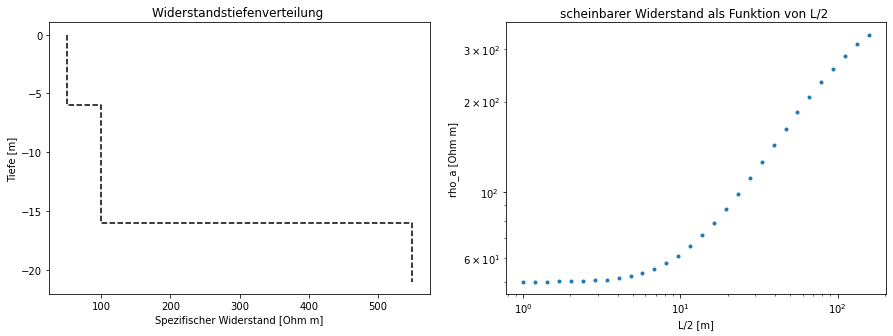

In [5]:
# Geben Sie für rho die spezifischen Widerstande der einzelenen Schichte an (mit Komma getrennt)

rho = np.array([50,100,550]); # Schichtwiderstände

# Geben Sie entsprechend die Schichtmächtigkeiten an (unterste Schicht = Halbraum)

d = np.array([6,10]); # Schichtmächtigkeiten


## Ab hier nichts mehr verändern
start_model = np.concatenate([rho,d])
# Inversionparameter
dx = .01 # Parameter für das numerische lösen des Intergrals (am besten so lassen)
n_max = 50; # Parameter für das numerische lösen des Intergrals (am besten so lassen)
fac = .15; # kontrolliert wie groß ein einzelnes Modellupdate sein soll
L_model = np.logspace(0,2.2,30)
# Inversion wird gestartet#
bessel = precompute_bessel_function(L_model,dx,n_max)
rho_a = forward_model_1(rho,d,L_model,bessel,dx,n_max)
#plot_single_model(data,rho_a)
plt.figure(figsize=(15,5))
plt.subplot(1,2,2)
plt.loglog(L_model,rho_a,'.')
plt.title('scheinbarer Widerstand als Funktion von L/2 ')
plt.xlabel('L/2 [m]')
plt.ylabel('rho_a [Ohm m]')
plt.subplot(1,2,1)
plot_model(rho,d)
plt.title('Widerstandstiefenverteilung ')
plt.show()
